# 1 - Introduction




In the last mission, we made our first submission to Kaggle, getting an accuracy score of 75.6%. While this is a good start, there is definitely room for improvement. There are two main areas we can focus on to boost the accuracy of our predictions:

- Improving the features we train our model on
- Improving the model itself

In this mission, we're going to focus working with the features used in our model.

We'll start by looking at **feature selection**. Feature selection is important because it helps to exclude features which are not good predictors, or features that are closely related to each other. Both of these will cause our model to be less accurate, particularly on previously unseen data.

The diagram below illustrates this. The red dots represent the data we are trying to predict, and each of the blue lines represents a different model.

<img width="400" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1kbrNc65A77r6QSOZpyX79WUdPhCVbVlb">


The model on the left is **overfitting**, which means the model represents the training data too closely, and is unlikely to predict well on unseen data, like the holdout data for our Kaggle competition.

The model on the right is **well-fit**. It captures the underlying pattern in the data without the detailed noise found just in the training set. A well fit model is likely to make accurate predictions on previously unseen data. The key to creating a well-fit model is to select the right balance of features, and to create new features to train your model.

In the previous mission, we trained our model using data about the age, sex and class of the passengers on the Titanic. Let's start by using the functions we created in that mission to add the columns we had at the end of the first mission.

Remember that any modifications we make to our training data (**train.csv**) we also have to make to our holdout data (**test.csv**).



In [3]:
# put your code here

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving test.csv to test.csv
Saving train.csv to train.csv
User uploaded file "test.csv" with length 28629 bytes
User uploaded file "train.csv" with length 61194 bytes


In [4]:
import pandas as pd

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df
  
train = process_age(train)
holdout = process_age(holdout)

for column in ["Age_categories","Pclass","Sex"]:
    train = create_dummies(train,column)
    holdout = create_dummies(holdout,column)

print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male'],
      dtype='object')


# 2 -  Preparing More Features




Our model in the previous mission was based on three columns from the original data: **Age**, **Sex**, and **Pclass**. As you saw when you printed the column names in the previous screen, there are a number of other columns that we haven't yet used. To make it easier to reference, the output from the previous screen is copied below:

```python
Index(['PassengerId', 'Survived', 'Pclass', 'Name',
       'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing',
       'Age_categories_Infant',
       'Age_categories_Child',
       'Age_categories_Teenager',
       'Age_categories_Young Adult',
       'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1',
       'Pclass_2', 'Pclass_3','Sex_female',
       'Sex_male'], dtype='object')
```

We can ignore **PassengerId**, since this is just a column Kaggle have added to identify each passenger and calculate scores. We can also ignore **Survived**, as this is what we're predicting, as well as the three columns we've already used.

Here is a list of the remaining columns (with a brief description), followed by 5 randomly selected passengers from and their data from those columns, so we can refamiliarize ourselves with the data.

- **SibSp** - The number of siblings or spouses the passenger had aboard the Titanic
- **Parch** - The number of parents or children the passenger had aboard the Titanic
- **Ticket** - The passenger's ticket number
- **Fare** - The fair the passenger paid
- **Cabin** - The passengers cabin number
- **Embarked** - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

At first glance, both the **Name** and **Ticket** columns look to be unique to each passenger. We will come back to these columns later, but for now we'll focus on the other columns.

We can use the **Dataframe.describe()** method to give us some more information on the values within each remaining column.

In [5]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
train[columns].describe(include='all')

,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,204,889
unique,NaN,NaN,NaN,147,3
top,NaN,NaN,NaN,B96 B98,S
freq,NaN,NaN,NaN,4,644
mean,0.523008,0.381594,32.204208,NaN,NaN
std,1.102743,0.806057,49.693429,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,NaN
25%,0.000000,0.000000,7.910400,NaN,NaN
50%,0.000000,0.000000,14.454200,NaN,NaN
75%,1.000000,0.000000,31.000000,NaN,NaN


In [6]:
train[columns].isnull().sum()

SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
holdout[columns].isnull().sum()

SibSp         0
Parch         0
Fare          1
Cabin       327
Embarked      0
dtype: int64

Of these, **SibSp**, **Parch** and **Fare** look to be standard numeric columns with no missing values. **Cabin** has values for only 204 of the 891 rows, and even then most of the values are unique, so for now we will leave this column also. **Embarked** looks to be a standard categorical column with 3 unique values, much like **PClass** was, except that there are two missing values. We can easily fill these two missing values with the most common value, **"S"** which occurs 644 times.

Looking at our numeric columns, we can see a big difference between the range of each. **SibSp** has values between 0-8, **Parch** between 0-6, and **Fare** is on a dramatically different scale, with values ranging from 0-512. In order to make sure these values are equally weighted within our model, we'll need to **rescale** the data.

Rescaling simply stretches or shrinks the data as needed to be on the same scale, in our case between 0 and 1.

<img width="400" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1gUe_kSss54VwGzmveizevZsFYB5lk3u1">


After rescaling, the values in each feature has been compressed or stretched so that they are all on the same scale - they have the same minimum and maximum, and the relationship between each point is still the same relative other points in that feature. You can now easily see that the data represented in each column is identical.

Within scikit-learn, the [preprocessing.minmax_scale()](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html) function allows us to quickly and easily rescale our data:

```python
from sklearn.preprocessing import minmax_scale
columns = ["column one", "column two"]
data[columns] = min_max_scale(data[columns])
```

Let's process the **Embarked**, **SibSp**, **Parch** and **Fare** columns in both our **train** and **holdout** dataframes.



In [8]:
from sklearn.preprocessing import minmax_scale
# The holdout set has a missing value in the Fare column which
# we'll fill with the mean.
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())
columns = ["SibSp","Parch","Fare"]

train["Embarked"] = train["Embarked"].fillna("S")
holdout["Embarked"] = holdout["Embarked"].fillna("S")

train = create_dummies(train,"Embarked")
holdout = create_dummies(holdout,"Embarked")

for col in columns:
    train[col + "_scaled"] = minmax_scale(train[col])
    holdout[col + "_scaled"] = minmax_scale(holdout[col])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [9]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled'],
      dtype='object')

# 3 - Determining the Most Relevant Features




In order to select the best-performing features, we need a way to measure which of our features are relevant to our outcome - in this case, the survival of each passenger. One effective way is by training a logistic regression model using all of our features, and then looking at the coefficients of each feature.

The scikit-learn [LogisticRegression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) has an attribute in which coefficients are stored after the model is fit, **LogisticRegression.coef_**. We first need to train our model, after which we can access this attribute.

>```python
lr = LogisticRegression()
lr.fit(train_X,train_y)
coefficients = lr.coef_
```

The **coef()** method returns a NumPy array of coefficients, in the same order as the features that were used to fit the model. To make these easier to interpret, we can convert the coefficients to a pandas series, adding the column names as the index:

>```python
feature_importance = pd.Series(coefficients[0],
                               index=train_X.columns)
```

We'll now fit a model and plot the coefficients for each feature.

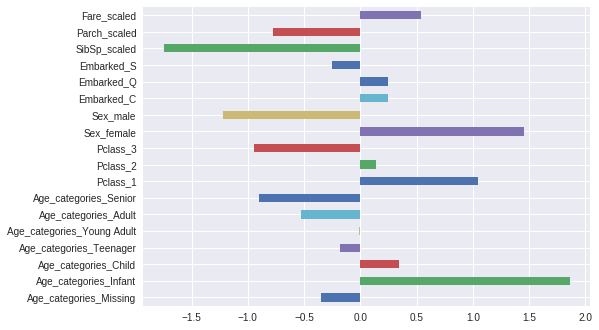

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

sns.set()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

lr = LogisticRegression()
lr.fit(train[columns],train['Survived'])

coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0],
                               index=columns)
feature_importance.plot.barh()

plt.show()

# 4 - Training a model using relevant features.




The plot we generated in the last section showed a range of both positive and negative values. Whether the value is positive or negative isn't as important in this case, relative to the magnitude of the value. If you think about it, this makes sense. A feature that indicates strongly whether a passenger died is just as useful as a feature that indicates strongly that a passenger survived, given they are mutually exclusive outcomes.

To make things easier to interpret, we'll alter the plot to show all positive values, and have sorted the bars in order of size:

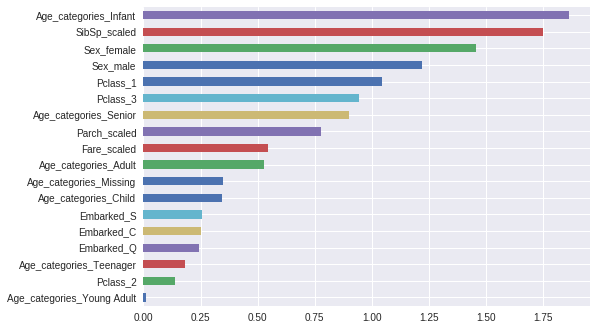

In [11]:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

We'll train a new model with the top 8 scores and check our accuracy using cross validation.

In [12]:
from sklearn.model_selection import cross_val_score

columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']
all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
print(accuracy)

0.8148019521053229


# 5 - Submitting our Improved Model to Kaggle




The cross validation score of 81.48% is marginally higher than the cross validation score for the model we created in the previous mission, which had a score of 80.2%.

Hopefully, this improvement will translate to previously unseen data. Let's train a model using the columns from the previous step, make some predictions on the holdout data and submit it to Kaggle for scoring.

In [0]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[columns])

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_2.csv",index=False)

# 6 - Engineering a New Feature Using Binning




When you submit it to Kaggle, you'll see that the store is 77.33%, which at the time of writing equates to jumping about 2,017 places up the leaderboard (this will vary as the leaderboard is always changing). It's only a small improvement, but we're moving in the right direction.

A lot of the gains in accuracy in machine learning come from **Feature Engineering**. Feature engineering is the practice of creating new features from your existing data.

One common way to engineer a feature is using a technique called **binning**. Binning is when you take a continuous feature, like the fare a passenger paid for their ticket, and separate it out into several ranges (or 'bins'), turning it into a categorical variable.

**This can be useful when there are patterns in the data that are non-linear and you're using a linear model (like logistic regression)**. We actually used binning in the previous mission when we dealt with the **Age** column, although we didn't use the term.

Let's look at histograms of the **Fare** column for passengers who died and survived, and see if there are patterns that we can use when creating our bins.

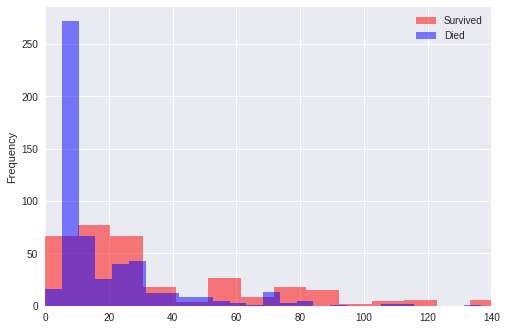

In [15]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]

survived["Fare"].plot.hist(alpha=0.5,color='red',bins=50)
died["Fare"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.xlim(0,140)
plt.show()

Looking at the values, it looks like we can separate the feature into four bins to capture some patterns from the data:

- 0-12
- 12-50
- 50-100
- 100+

Like in the previous mission, we can use the **pandas.cut()** function to create our bins.

In [0]:
def process_fare(df,cut_points,label_names):
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

cut_points = [0,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]

train = process_fare(train,cut_points,label_names)
holdout = process_fare(holdout,cut_points,label_names)

train = create_dummies(train,"Fare_categories")
holdout = create_dummies(holdout,"Fare_categories")

In [17]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled', 'Fare_categories',
       'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Fare_categories_100+'],
      dtype='object')

# 7 - Engineering Features From Text Columns




Another way to engineer features is by extracting data from text columns. Earlier, we decided that the **Name** and **Cabin** columns weren't useful by themselves, but what if there is some data there we could extract? Let's take a look at a random sample of rows from those two columns:

|  |        Name                                   |   Cabin         |
|------|---------------------------------------------------|---------|
| 772  | Mack, Mrs. (Mary)                                 | E77     |
| 148  | Navratil, Mr. Michel ("Louis M Hoffman")          | F2      |
| 707  | Calderhead, Mr. Edward Pennington                 | E24     |
| 879  | Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)     | C50     |
| 21   | Beesley, Mr. Lawrence                             | D56     |
| 456  | Millet, Mr. Francis Davis                         | E38     |
| 97   | Greenfield, Mr. William Bertram                   | D10 D12 |
| 263  | Harrison, Mr. William                             | B94     |
| 393  | Newell, Miss. Marjorie                            | D36     |
| 759  | Rothes, the Countess. of (Lucy Noel Martha Dye... | B77     |

While in isolation the cabin number of each passenger will be reasonably unique to each, we can see that the format of the cabin numbers is one letter followed by two numbers. It seems like the letter is representative of the type of cabin, which could be useful data for us. We can use the pandas [Series.str accessor](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.html) and then subset the first character using brackets:




In [18]:
train.head()["Cabin"]

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [19]:
train.head()["Cabin"].str[0]

0    NaN
1      C
2    NaN
3      C
4    NaN
Name: Cabin, dtype: object

Looking at the **Name** column, There is a title like 'Mr' or 'Mrs' within each, as well as some less common titles, like the 'Countess' from the final row of our table above. By spending some time researching the different titles, we can categorize these into six types:

- Mr
- Mrs
- Master
- Miss
- Officer
- Royalty

We can use the [Series.str.extract](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.extract.html) method and a [regular expression](https://en.wikipedia.org/wiki/Regular_expression) to extract the title from each name and then use the [Series.map()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method and a predefined dictionary to simplify the titles.

>```python
titles = {
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Countess":    "Royalty",
    "Lady" :       "Royalty"
}
extracted_titles = train["Name"].str.extract('([A-Za-z]+)\.', expand=False)
train["Title"] = extracted_titles.map(titles)
```

In [0]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["Name"].str.extract('([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)

extracted_titles = holdout["Name"].str.extract('([A-Za-z]+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

train["Cabin_type"] = train["Cabin"].str[0]
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")

holdout["Cabin_type"] = holdout["Cabin"].str[0]
holdout["Cabin_type"] = holdout["Cabin_type"].fillna("Unknown")

for column in ["Title","Cabin_type"]:
    train = create_dummies(train,column)
    holdout = create_dummies(holdout,column)

In [21]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled', 'Fare_categories',
       'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Fare_categories_100+', 'Title', 'Cabin_type',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown'],
      dtype='object')

# 8 - Finding Correlated Features




We now have a lot of possible feature columns we can use to train our model. One thing to be aware of as you start to add more features is a concept called **collinearity**. Collinearity occurs where more than one feature contains data that are similar.

The effect of collinearity is that your model will overfit - you may get great results on your test data set, but then the model performs worse on unseen data (like the holdout set).

One easy way to understand collinearity is with a simple binary variable like the **Sex** column in our dataset. Every passenger in our data is categorized as either male or female, so 'not male' is exactly the same as 'female'.

As a result, when we created our two dummy columns from the categorical **Sex** column, we've actually created two columns with identical data in them. This will happen whenever we create dummy columns, and is called the [dummy variable trap](http://www.algosome.com/articles/dummy-variable-trap-regression.html). The easy solution is to choose one column to drop any time you make dummy columns.

Collinearity can happen in other places, too. A common way to spot collinearity is to plot correlations between each pair of variables in a heatmap. An example of this style of plot is below:

<img width="400" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1N9dZIsRqpUjfgSyR0d8casbdtS90CnXU">


The darker squares, whether the darker red or darker blue, indicate pairs of columns that have higher correlation and may lead to collinearity. The easiest way to produce this plot is using the [DataFrame.corr()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) method to produce a correlation matrix, and then use the Seaborn library's [seaborn.heatmap()](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function to plot the values:

>```python
import seaborn as sns
correlations = train.corr()
sns.heatmap(correlations)
plt.show()
```

The example plot above was produced using a [code example from seaborn's documentation](http://seaborn.pydata.org/examples/many_pairwise_correlations.html) which produces an correlation heatmap that is easier to interpret than the default output of **heatmap()**. We've created a function containing that code to make it easier for you to plot the correlations between the features in our data.

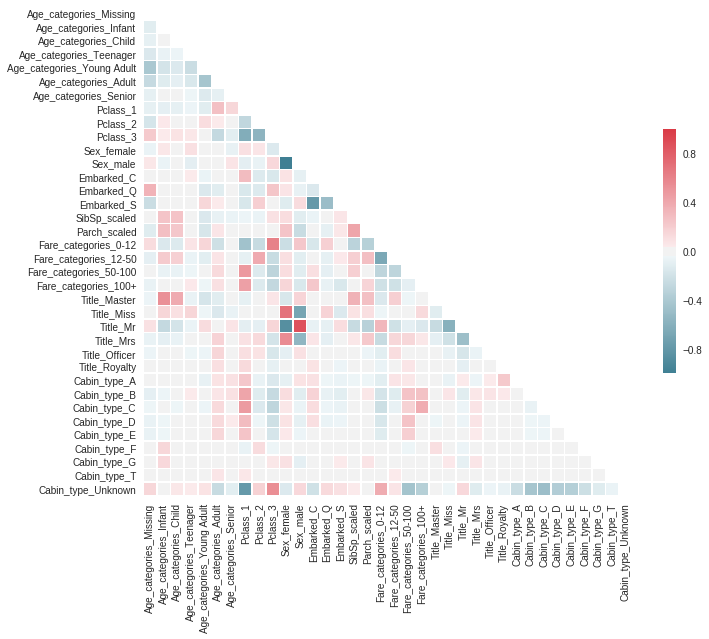

In [22]:
import numpy as np
import seaborn as sns

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']
plot_correlation_heatmap(train[columns])

# 9 - Final Feature Selection using RFECV




From the plot above we can see that there is a high correlation between **Sex_female/Sex_male** and **Title_Miss/Title_Mr/Title_Mrs**. We will remove the columns **Sex_female** and **Sex_male** since the title data may be more nuanced.

Apart from that, we should remove one of each of our dummy variables to reduce the collinearity in each. We'll remove:

- Pclass_2
- Age_categories_Teenager
- Fare_categories_12-50
- Title_Master
- Cabin_type_A

In an earlier step, we manually used the logit coefficients to select the most relevant features. An alternate method is to use one of scikit-learn's inbuilt feature selection classes. We will be using the [feature_selection.RFECV](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) class which performs **recursive feature elimination** with cross-validation.

The **RFECV** class starts by training a model using all of your features and scores it using cross validation. It then uses the logit coefficients to eliminate the least important feature, and trains and scores a new model. At the end, the class looks at all the scores, and selects the set of features which scored highest.

Like the **LogisticRegression** class, **RFECV** must first be instantiated and then fit. The first parameter when creating the **RFECV** object must be an estimator, and we need to use the **cv** parameter to specific the number of folds for cross-validation.

>```python
from sklearn.feature_selection import RFECV
lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(all_X,all_y)
```

Once the **RFECV** object has been fit, we can use the **RFECV.support_** attribute to access a boolean mask of True and False values which we can use to generate a list of optimized columns:

>```python
optimized_columns = all_X.columns[selector.support_]
```

In [0]:
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]
lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(all_X,all_y)

optimized_columns = all_X.columns[selector.support_]

In [24]:
optimized_columns

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')

# 10 - Training A Model Using our Optimized Columns




The **RFECV()** selector returned only four columns:

>```python
['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown']
```

Let's train a model using cross validation using these columns and check the score.

In [25]:
all_X = train[optimized_columns]
all_y = train["Survived"]

lr = LogisticRegression()

scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
accuracy

0.8226549199863807

# 11 - Submitting our Model to Kaggle




This four-feature model scores 82.26%, a modest improvement compared to the 81.5% from our earlier model. Let's train these columns on the holdout set, save a submission file and see what score we get from Kaggle.


In [0]:
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[optimized_columns])

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_3.csv",index=False)

<img width="500" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1g_9YwzJB1I2c9hEWVsNN6LdfCo2dK2qN">

# 12 - Next Steps




The score this submission gets is 78.46%, which is equivalent to a jump of roughly 1,983 spots (again, this will vary as submission are constantly being made to the leaderboard).

By preparing, engineering and selecting features, we have increased our accuracy by 2.4%. When working in Kaggle competitions, you should spend a lot of time experimenting with features, particularly feature engineering.

Here are some ideas that you can use to work with features for this competition:

- Use **SibSp** and **Parch** to explore total relatives onboard.
- Create combinations of multiple columns, for instance **Pclass + Sex**.
- See if you can extract useful data out of the **Ticket** column.
- Try different combinations of features to see if you can identify features that overfit less than others.

In the next mission in this course, we'll look at selecting and optimizing different models to improve our score.